## Importing all modules in cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable, Iterable

## Load dummy 1-2-3 digit dataset

In [2]:
data = np.loadtxt('../support/zipcombo.dat')
# data_123 = np.loadtxt('../support/dtrain123.dat')

In [3]:
data.shape

(9298, 257)

We now define functions for splitting the dataset into train/test and input/label.

In [4]:
def split_80_20(data: np.ndarray, seed: int) -> (np.ndarray, np.ndarray):
    """
    Splits 80% train 20% test

    :param data: sequence.
    :param seed: Random seed used to shuffle given data.
    :return: train_data, test_data: np.ndarray, np.ndarray
    """
    np.random.seed(seed)
    n = data.shape[0]
    shuffle = np.random.permutation(data)
    train_size = int(n*0.8)
    return shuffle[:train_size], shuffle[train_size:]

In [5]:
def split_X_y(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits the data into datapoints and labels, X_train matrix and y_train;
    :param data: np.ndarray
    :return: X_train, y_train: np.ndarray, np.ndarray
    """

    return data[:, 1:], data[:, 0]

In [6]:
def shuffle_split(data):
    data_train, data_test = split_80_20(data, seed=637)
    X_train, y_train = split_X_y(data_train)
    X_test, y_test = split_X_y(data_test)

    assert X_train.shape[0] == y_train.size
    assert X_test.shape[0] == y_test.size

    print("Train data set size = %d" % X_train.shape[0])
    print("Test data set size = %d" % X_test.shape[0])

    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = shuffle_split(data)

Train data set size = 7438
Test data set size = 1860


In [8]:
def display_digit(grayscale):
    plt.imshow(np.reshape(grayscale, (16, 16)), cmap='gray')

3.0


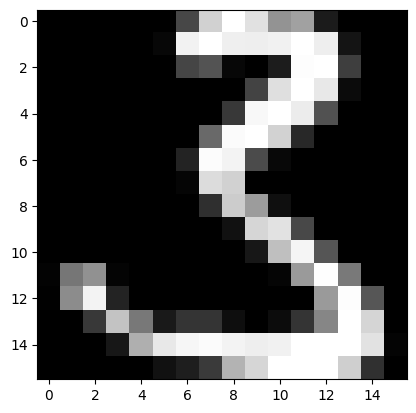

In [9]:
display_digit(X_train[100])
print(y_train[100])

Let us now define the Kernel Perceptron algorithm and kernel functions to be used.

In [10]:
def polynomial_kernel(x_i: np.ndarray, x_t: np.ndarray, d: int):
    return np.inner(x_i, x_t) ** d

In [11]:
def gaussian_kernel(x_i: np.ndarray, x_j: np.ndarray, sigma=1):
    if x_i.shape[0] != x_j.shape[0]:
        raise Exception("Cannot apply kernel to vectors of different dimensions: x_i has shape {s1}, x_j has shape {s2}"
                        .format(s1=x_i.shape, s2=x_j.shape))
    diff = x_i - x_j
    return np.exp(-1 * np.inner(diff, diff) / (2 * sigma**2))

In [13]:
class KernelPerceptron:
    def __init__(self, kernel: Callable[[np.ndarray, np.ndarray], float], size: int):
        self.kernel = kernel
        self.K = None
        self.alpha = np.zeros(size)
        self.X_train = None

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        K = np.zeros((X_train.shape[0], X_train.shape[0]))

        for i in range(0, X_train.shape[0]):
            for j in range(i, X_train.shape[0]):
                K[i, j] = K[j, i] = self.kernel(X_train[i], X_train[j])

        return K

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, n_epochs: int) -> np.ndarray:
        """
        Prediction function that populates the alpha parameter, 1 data point at a time;
        :param X_train: training data points
        :param y_train: training corresponding labels
        :param n_epochs: number of times to pass through the data. Alpha contains the learning parameters that get inherited from one epoch to the other
        :return: y_preds: the predictions enhanced after N epochs

        """
        if y_train.ndim != 1:
            raise Exception('y_train must be a 1-dim np.ndarray. Given y_train with shape {s}'.format(s=y_train.shape))
        if X_train.shape[0] != y_train.size:
            raise Exception('X_train and y_train must contain equal number of samples. Given X_train with shape {s1} and y_train with shape {s2}'.format(s1=y_train.shape, s2=X_train.shape))

        y_preds = np.zeros(X_train.shape[0])
        self.X_train = X_train

        # Compute kernel matrix which stays constant throughout the algorithm and all epochs
        self.K = self._get_kernel_matrix(X_train)

        for epoch in range(0, n_epochs):
            for t in range(0, X_train.shape[0]):
                y_pred = self._predict_single(t)
                y_preds[t] = y_pred
                if y_pred != y_train[t]:
                    self.alpha[t] += y_train[t]
        return y_preds

    def _predict_single(self, t: int):
        """
        We take a whole row of kernel matrix K because in we want to account for errors in previous epochs.
        This is not an issue in the first epoch because all alpha's > t are 0.
        :param t: iteration step in the online learning algorithm.
        :return: y hat, single predicted value at step t.
        """
        return np.sign(np.inner(self.K[t, :], self.alpha))

    def yhat_single(self, K, t: int):
        return np.sign(np.inner(K[t, :], self.alpha))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Prediction function to be used for out-of-sample test data point.
        Does not perform online learning (update step).
        :param X: test data points.
        :return: np.ndarray of predictions for each given test data point.
        """
        predictions = []
        for x_test in X:
            sum = 0
            for t in range(self.X_train.shape[0]):
                # Can improve by using kernel matrix
                sum += self.alpha[t] * self.kernel(self.X_train[t], x_test)
            predictions.append(np.sign(sum))
        return np.array(predictions)


# kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
# y_insample = kp.fit(X_train_12, y_train_12, n_epochs=2)

In [12]:
def get_error_percentage(y_train, y_insample, y_test, y_outsample):
    print("in-sample = % " + str(100 * get_num_mistakes(actual=y_train, predicted=y_insample) / y_train.size))
    print("out-of-sample = % " + str(100 * get_num_mistakes(actual=y_test, predicted=y_outsample) / y_test.size))

def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

class KPOneVsAllClassifier():
    def __init__(self, kernel, n_classes, d):
        self.kernel = kernel
        self.n_classes = n_classes # could optimize to remove this var since =k.shape[0]
        self.d = d
        self.X_train = None
        self.Alpha = None
        self.K = None

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        K = np.zeros((X_train.shape[0], X_train.shape[0]))
        for i in range(0, X_train.shape[0]):
            for j in range(i, X_train.shape[0]):
                K[i, j] = K[j, i] = self.kernel(X_train[i], X_train[j], d=self.d)
        return K

    def sign(self, x: np.ndarray) -> np.ndarray:
        return np.where(x <= 0, 1, -1)

    def _predict_single_confidence(self, t, y_train):
        confidence = np.array(np.zeros(self.n_classes))

        # Get prediction array P
        preds = np.inner(self.K[t, :], self.Alpha[:, t])

        # Get Y_t array of ground truth (duplicate y_t)
        y = np.full(self.n_classes, -1)
        y[y_train[t]] = 1

        # penilize the ones that do not have
        self.Alpha[:, t] -= np.heaviside(-(preds * y), 1) * self.sign(preds)
        # for each perceptron
        # for cl in range(self.n_classes):
        #     # create and save predictions
        #     pred = np.inner(self.K[t, :], perceptrons[cl].alpha)
        #     confidence[cl] = pred
        #
        #     y = 1 if y_train[t] == float(cl) else (-1)
        #     ## penalize if the prediction wrong
        #     if y*pred <= 0:
        #         perceptrons[cl].alpha[t] -= self.sign(pred)
        return confidence

    def fit(self, X_train, y_train, n_epochs):
        y_preds = np.array(np.zeros(X_train.shape[0]))

        self.K = self._get_kernel_matrix(X_train)
        self.Alpha = np.zeros((self.n_classes, X_train.shape[0]))
        self.X_train = X_train

        for epoch in range(n_epochs):
            # for each point, calculate confidence and make predictions
            for t in range(0, X_train.shape[0]):
                confidence = self._predict_single_confidence(t, y_train)
                # the index with the highest number(confidence) is the prediction
                # +1 because the index for confidence in perceptron[1] is 0
                y_preds[t] = np.argmax(confidence) + 1
        return y_preds

    def _choose_best_ytest(self, yhats):
        # get the classifiers that predicted positive
        maxims = np.argwhere(yhats == np.amax(yhats)).flatten() + 1
        if maxims.shape[0] == 1:
            # if only 1 classifier predicts positive, take that class
             return maxims[0]
        else:
            # if more than one predicted positive, or all of them negative, choose one randomly
            return np.random.choice(maxims)

    def predict(self, X_test: np.ndarray):
        ypreds = np.array(np.zeros(X_test.shape[0]))# *(x, y) => kernel(x, y)
        partial_kernels = np.array([partial(self.kernel, X_train)(X_test)])
        ## for polynomial kernel
        self.K_test = np.power(X_train @ X_test.T, self.d)       #shape (X_test.shape[0], X_train.shape[0])


        for t_test in range(X_test.shape[0]):
            # yhats_sums = np.array(np.zeros(self.n_classes))
            # for cl in range(self.n_classes):
            #     # update
            #     sum = np.inner(self.Alpha[:, t])
            #     for t in range(self.X_train.shape[0]):
            #         sum += self.perceptrons[cl].alpha[t] * self.kernel(self.X_train[t], X_test[t_test], self.d)
            #     yhats_sums[cl] = sum

            yhats_sums = self.Alpha @ self.K_test[t_test]
            ypreds[t_test] = self._choose_best_ytest(yhats_sums)
        return ypreds


### for in-cell debug
# kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=3, d=3)
# kpova.fit(X_train, y_train, n_epochs=1)
# y_insample = kpova.predict(X_train)
# y_outsample = kpova.predict(X_test)
#
# get_error_percentage(y_train, y_insample, y_test, y_outsample)

In [22]:
np.power(X_train @ X_test.T, 3)

array([[ 1.27516459e+06,  5.29563896e+04,  4.52716428e+06, ...,
         7.34842826e+05,  7.27688975e+05,  3.17771279e+06],
       [ 1.50296007e+05,  6.72671667e+04,  1.26476136e+06, ...,
         4.60040898e+05,  1.05934857e+05,  1.62002147e+06],
       [ 1.50912288e+06,  8.94191319e+04,  4.89804523e+06, ...,
         7.14841827e+05,  8.11351027e+05,  4.11363711e+06],
       ...,
       [ 1.57089690e+06,  4.90355094e+05,  9.67786969e+01, ...,
        -3.83566786e+02,  1.22107783e+05,  3.81519314e+03],
       [ 1.01414542e+06,  9.56547743e+04,  3.03249680e+06, ...,
         3.74821378e+05,  5.28312719e+05,  2.60931244e+06],
       [ 1.20936351e+06,  4.87168232e+04,  8.53799935e+05, ...,
         5.54821957e+05,  2.06300183e+05,  9.07853478e+05]])

In [29]:
import time

start = time.time()

kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=3)
kpova.fit(X_train, y_train, n_epochs=1)
y_insample = kpova.predict(X_train)
y_outsample = kpova.predict(X_test)

end = time.time()

print("took :{t}".format(t=end-start))

get_error_percentage(y_train, y_insample, y_test, y_outsample)

took :1764.5372784137726
in-sample = % 18.392040871201935
out-of-sample = % 21.72043010752688


### _Tests_

Let us test the Kernel Perceptron implementation on a dummy dataset of only digits 1 and 2.

In [18]:
# Filter out digit 3 (leave only digit 1 and 2) from dtrain123.dat train and test dataset
indxs_digit_3 = np.where(y_train_123 == 3)
X_train_12 = np.delete(X_train_123, indxs_digit_3, axis=0)
y_train_12 = np.delete(y_train_123, indxs_digit_3)
y_train_12[y_train_12 == 1] = -1
y_train_12[y_train_12 == 2] = 1

indxs_digit_3 = np.where(y_test_123 == 3)
X_test_12 = np.delete(X_test_123, indxs_digit_3, axis=0)
y_test_12 = np.delete(y_test_123, indxs_digit_3)
y_test_12[y_test_12 == 1] = -1
y_test_12[y_test_12 == 2] = 1

assert X_train_12.shape[0] == y_train_12.size
assert X_test_12.shape[0] == y_test_12.size

In [21]:
# Test fitting and in-sample predictions
kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=5), size=X_train_12.shape[0])
y_insample = kp.fit(X_train_12, y_train_12, n_epochs=2)
# Test out-of-sample predictions
y_outsample = kp.predict(X_test_12) # all predictions of test sample in y_outsample
print("in-sample = % " + str(100 * get_num_mistakes(actual=y_train_12, predicted=y_insample) / y_train_12.size))
print("out-of-sample = % " + str(100 * get_num_mistakes(actual=y_test_12, predicted=y_outsample) / y_test_12.size))

in-sample = % 0.0
out-of-sample = % 1.8518518518518519


In [69]:
## Test the kernel matrix
kp_test = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
kernel_matrix = kp_test._get_kernel_matrix(X_train_12)
polynomial_kernel(X_train_12[0], X_train_12[0], d=3) == kernel_matrix[0][0]

TypeError: KernelPerceptron.__init__() missing 1 required positional argument: 'size'

## *_Part 1_*

1. *Basic results*
- for $d=1, ... ,7$ perform 20 runs
- split $zipcombo$ 80-20
- report MSE and STD
- yield a 2x7 table that has on each cell $mean+-std$


In [ ]:
means_train = []
means_test = []
stds_train = []
stds_test = []

for d in range(1, 8):
    train_errors = []
    test_errors = []
    for run in range(20):
        X_train, y_train, X_test, y_test = shuffle_split(data)

        kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=d)

        #train
        kpova.fit(X_train, y_train, n_epochs=1)
        y_insample = kpova.predict(X_train)
        #test
        y_outsample = kpova.predict(X_test)

        train_errors.append(get_error_percentage(y_train, y_insample))
        test_errors.append(get_error_percentage(y_test, y_outsample))
    means_train.append(np.mean(train_errors))
    means_test.append(np.mean(test_errors))
    stds_train.append(np.std(train_errors))
    stds_test.append(np.std(test_errors))

In [ ]:
import pandas as pd


pd.DataFrame({
    'mean train': [str(x) + u"\u00B1" + str(y) for (x, y) in zip(means_train, stds_train)],
    'mean test': [str(x) + u"\u00B1" + str(y) for (x, y) in zip(means_test, stds_test)],
})

2. _Cross validation_
- perform 20 runs
- select "best" parameter $d*$ using 5-fold cross-validation
- retrain on 80% training using $d*$ and record the test errors for 20%
- findings: 20 $d*$ and 20 test errors
- output: mean_test_error$\pm$std, mean_$d*\pm$std

possible optimizations:
- in predict_single_confidence, try to fill the confidence vector for all perceptrons in 1 numpy operation
- in predict_single_confidence, try to compose the y*pred with an np.inner and then go and update the alphas